In [21]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from core.preprocessing.uk_holidays import retrieve_holiday_dates
from core.preprocessing.prepare_data import fill_zero_consumptions, fill_missing_weather_data
from data.sample_split import create_sample_split
from core.feature_engineering.feature_creation import create_features
from core.visualisation.plot_utils import boxplot_electricity_consumption, plot_week_consumption
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [13]:
DEMAND_DATA_PATH = Path.cwd().parent / 'data' / 'demand_data' / 'historic_demand_2009_2024.csv'
WEATHER_DATA_PATH = Path.cwd().parent / 'data' / 'weather_data' / 'all_weather_data.csv'

df_demand = pd.read_csv(DEMAND_DATA_PATH, index_col=0)
df_weather = pd.read_csv(WEATHER_DATA_PATH, index_col=0)

# Change column names to lower case and drop id (row number)
df_demand.columns = df_demand.columns.str.lower()
df_demand.head()


,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
0,2009-01-01,1,37910,38704,33939,54,1403,0,0,0,...,0,0,-161,0,0,NaN,NaN,NaN,NaN,1
1,2009-01-01,2,38047,38964,34072,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
2,2009-01-01,3,37380,38651,33615,53,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
3,2009-01-01,4,36426,37775,32526,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1
4,2009-01-01,5,35687,37298,31877,50,1403,0,0,0,...,0,0,-160,0,0,NaN,NaN,NaN,NaN,1


## Data understanding

The [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) includes a description of all the columns. It is intuitive that the inflow and outflow of the connection channels in the dataset has little contribution to the predication of UK demand. The generation of wind and solar also have little impact in electricity demand. Hence I will use the 3 columns below and drop the other columns. I will introduce the weather data and join with the demand for the prediction of the UK electricity demand.

* SETTLEMET_DATA: date in format dd/mm/yyyy
* SETTLEMENT_PERIOD: half hourly period for the historic outtunr occurred
* TSD (Transmission System Demand). Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

TSD is target variable and the aim is to predict the future demand using different models.

In [14]:
df_demand.describe()

,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,...,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday
count,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,...,278592.000000,278592.000000,278592.000000,278592.000000,278592.000000,103296.000000,103296.000000,33168.000000,33168.000000,278592.000000
mean,24.500230,31186.856489,32627.150352,28388.517068,1266.183760,4442.451068,878.978851,8664.639013,6.670271,304.958427,...,52.560770,504.322741,-125.472042,-50.637086,175.249849,413.590420,114.916696,1687.110498,187.359594,0.022571
std,13.853822,7830.469632,7713.762584,7090.759507,960.981771,1956.656441,1710.119384,5867.370555,39.196603,528.734713,...,352.310414,541.202147,230.119018,262.791267,421.016595,650.851017,491.937519,1819.688334,555.345444,0.148530
min,1.000000,13367.000000,0.000000,0.000000,0.000000,1403.000000,0.000000,0.000000,-24.000000,0.000000,...,-1030.000000,-1215.000000,-505.000000,-585.000000,-1023.000000,-1455.000000,-1028.000000,-2851.000000,-1465.000000,0.000000
25%,12.750000,24906.000000,26580.000000,22674.000000,550.000000,2098.000000,0.000000,2024.750000,0.000000,8.000000,...,0.000000,0.000000,-303.000000,-207.000000,0.000000,0.000000,0.000000,262.000000,0.000000,0.000000
50%,24.500000,30492.000000,31780.000000,27752.000000,1014.000000,4831.000000,0.000000,11503.000000,0.000000,11.000000,...,0.000000,726.000000,-149.000000,0.000000,0.000000,0.000000,0.000000,1523.000000,0.000000,0.000000
75%,36.250000,36915.000000,38096.000000,33616.000000,1722.000000,6527.000000,884.000000,13080.000000,0.000000,367.000000,...,0.000000,994.000000,24.000000,0.000000,324.000000,1095.000000,93.000000,3021.000000,428.250000,0.000000
max,50.000000,59095.000000,60147.000000,53325.000000,5587.000000,6622.000000,11224.000000,17197.000000,893.000000,2019.000000,...,1016.000000,1143.000000,499.000000,504.000000,1033.000000,1401.000000,1002.000000,6585.000000,1436.000000,1.000000


In [15]:
df_demand.shape

(278592, 22)

In [16]:
df_demand.columns

Index(['settlement_date', 'settlement_period', 'nd', 'tsd',
       'england_wales_demand', 'embedded_wind_generation',
       'embedded_wind_capacity', 'embedded_solar_generation',
       'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping',
       'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow',
       'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer',
       'viking_flow', 'is_holiday'],
      dtype='object')

In [17]:
# There are Nan values in the nsl_flow, eleclink_flow and scottish_transfer, viking_flow columns that is due to the fact that the data is not available for the years 2020-2024. We will drop these columns as they are not relevant for our analysis.
# the channels are not in operation before certain years hence the flow data is Nan. We will drop these columns as they are not 
# relevant for our analysis.
df_demand.isna().any()
df_demand_clean = df_demand[['settlement_date', 'settlement_period', 'tsd', 'is_holiday']]

# Sort values by date
df_demand_clean.sort_values(by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True)

/var/folders/g2/rxb_hqs14sj0lzydxpy6nmw40000gn/T/ipykernel_82061/3588579965.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_clean.sort_values(by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True)


In [18]:
df_demand_clean.shape

(278592, 4)

In [19]:
# Each year UK changes clock in the last Sunday of March and October. 
# This means that the number of settlement periods in a day changes from 48 to 46 and from 48 to 50. 
# I will check if the dataset has the correct number of settlement periods at clock change days
period_counts = df_demand_clean.groupby('settlement_date')['settlement_period'].count()
clock_change_dates = period_counts[period_counts != 48]
print(f"clock change dates from 2009 to 2024: {clock_change_dates}")

clock change dates from 2009 to 2024: settlement_date
2009-03-29    46
2009-10-25    50
2010-03-28    46
2010-10-31    50
2011-03-27    46
2011-10-30    50
2012-03-25    46
2012-10-28    50
2013-03-31    46
2013-10-27    50
2014-03-30    46
2014-10-26    50
2015-03-29    46
2015-10-25    50
2016-03-27    46
2016-10-30    50
2017-03-26    46
2017-10-29    50
2018-03-25    46
2018-10-28    50
2019-03-31    46
2019-10-27    50
2020-03-29    46
2020-10-25    50
2021-03-28    46
2021-10-31    50
2022-03-27    46
2022-10-30    50
2023-03-26    46
2023-10-29    50
2024-03-31    46
2024-10-27    50
Name: settlement_period, dtype: int64


In [22]:
# Bank holidays are very important in demand forecasting as the electricity demand on a holiday is often very low comparing with non-holidays. 
# The dataset has is_holiday columns. Next is to verify the holiday dates.
# Online there is [Python Holidays API](https://python-holidays.readthedocs.io/en/latest/api.html) I use to get UK holidays and verify the dates in the dataset.
to_date = pd.to_datetime(df_demand_clean['settlement_date']).max().date()
holiday_dates = retrieve_holiday_dates(subdiv='England', 
                                       from_date=dt.date(2009, 1, 1), 
                                       to_date=to_date)
holiday_dates_in_data = df_demand_clean[df_demand_clean['is_holiday'] == 1]['settlement_date'].unique()

missing_holidays = set(holiday_dates) - set(holiday_dates_in_data)
print(f"Missing holidays in data: {missing_holidays}")



Missing holidays in data: set()


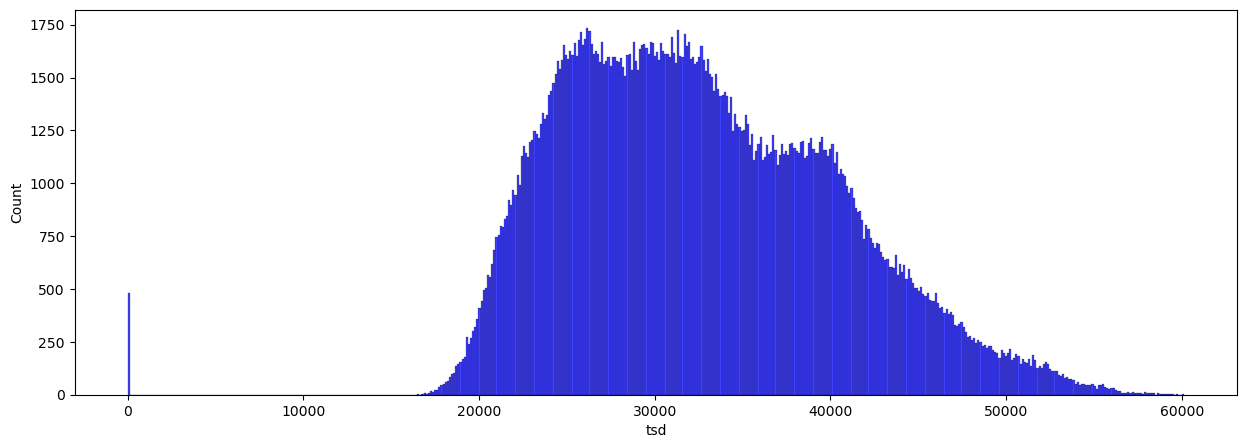

In [23]:
# There are some outliers 0 values in the demand data
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df_demand_clean, x="tsd", bins=500, ax=ax, color="b");

In [24]:
df_demand_clean = fill_zero_consumptions(df_demand_clean)

/Users/lizzy/JavaPythonProjects/Mphil/d100_ds/uk_electricity_consumption/core/preprocessing/prepare_data.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year"] = pd.to_datetime(df["settlement_date"]).dt.year


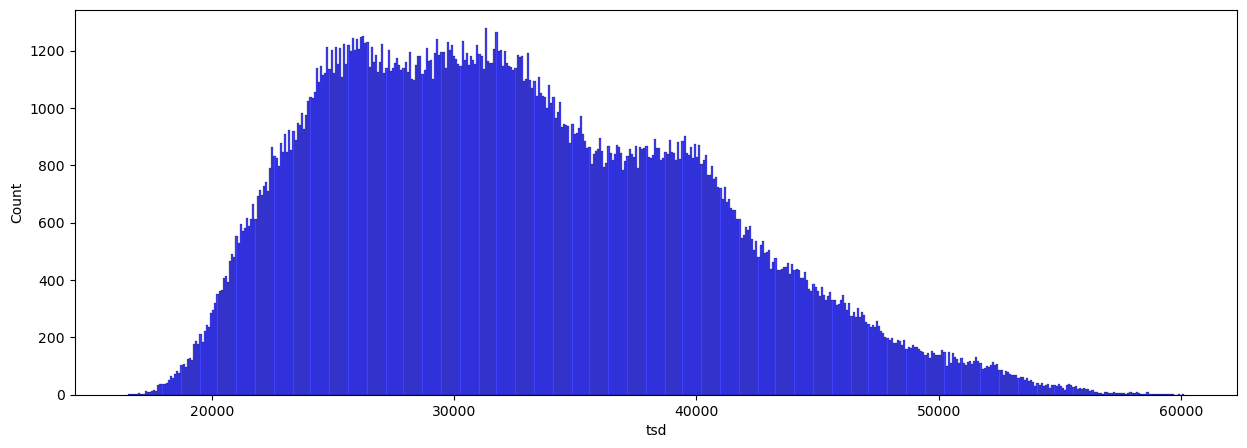

In [25]:
# Check if there are still 0 values in the demand data
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(data=df_demand_clean, x="tsd", bins=500, ax=ax, color="b");

## Weather data understanding

In [26]:
# Check if there are any missing values in the weather data
df_weather.isna().any()

date                        False
min_temp °c                 False
max_temp °c                 False
rain mm                     False
humidity %                  False
cloud_cover %               False
wind_speed km/h             False
wind_direction              False
wind_direction_numerical    False
dtype: bool

In [27]:
# Daily weather data by each location. I take the average of the weather data of all locations as the daily weather for UK national wide.
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather_by_date = df_weather.groupby('date')[['min_temp °c', 'max_temp °c', 'rain mm', 'humidity %',
       'cloud_cover %', 'wind_speed km/h']].mean()

In [28]:
# Check if there are any missing dates in the weather data
date_range = pd.date_range(start="2009-01-01", end="2024-11-12")
df_weather_by_date = df_weather_by_date.reindex(date_range)

In [29]:
# After the reindexing, there are missing values in the weather data.
df_weather_by_date.isna().any()

min_temp °c        True
max_temp °c        True
rain mm            True
humidity %         True
cloud_cover %      True
wind_speed km/h    True
dtype: bool

In [30]:
# Fill nan values in the weather data and check again
df_weather_by_date = fill_missing_weather_data(df_weather_by_date)
df_weather_by_date.isna().any()


min_temp °c        False
max_temp °c        False
rain mm            False
humidity %         False
cloud_cover %      False
wind_speed km/h    False
dtype: bool

In [31]:
df_weather_by_date.describe()

,min_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h
count,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000
mean,7.226171,13.290816,2.501653,82.331236,56.144717,16.041526
std,4.430651,5.354706,2.999540,6.150038,18.706228,5.827452
min,-6.660040,-1.155070,0.000000,43.664016,1.600398,4.000000
25%,3.818273,9.159046,0.364911,78.311133,43.428429,11.736581
50%,7.265873,13.198807,1.406362,82.628231,57.691849,15.093254
75%,10.918489,17.653704,3.467825,86.791252,70.028827,19.403579
max,22.000000,32.369781,30.169841,98.528827,98.000000,57.000000


## EDA and Feature Creation
In this section, I visualise the data that has been prepared in order to understand the original feature. The consumption exihibits strong seasonanity as expected and slightly descrease trend by year. So I add new features that constits of different bits of information embedded in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions.

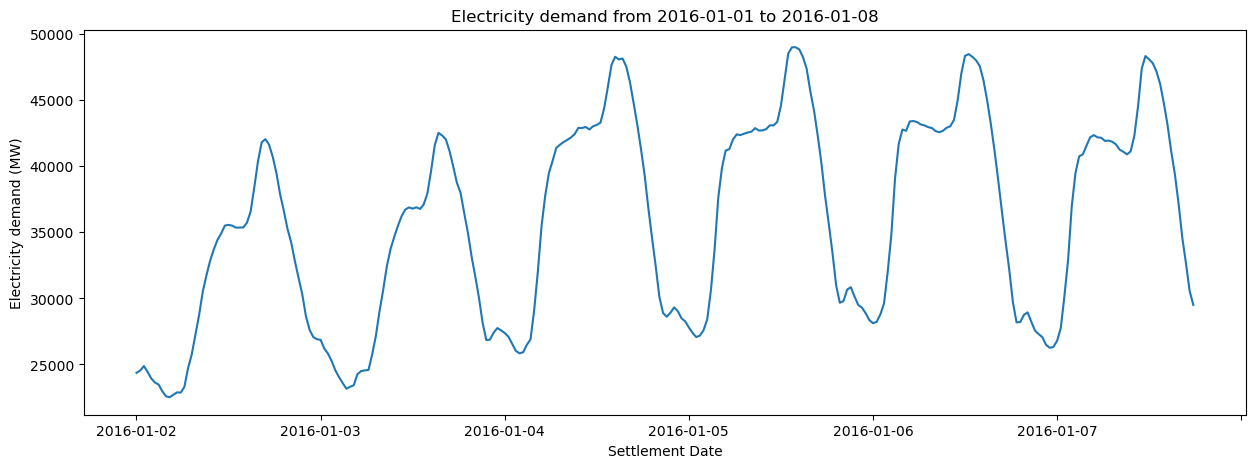

In [32]:
df_demand_clean.set_index("settlement_date", inplace=True)
df_demand_clean.sort_index(inplace=True)

plot_week_consumption(df_demand_clean, 
                      "2016-01-01", 
                      "2016-01-08", 
                      xlabel="Settlement Date", 
                      ylabel="Electricity demand (MW)",
                      title="Electricity demand from 2016-01-01 to 2016-01-08")

In [33]:
df_demand_clean.index = pd.to_datetime(df_demand_clean.index)
df_demand_clean = create_features(df_demand_clean)

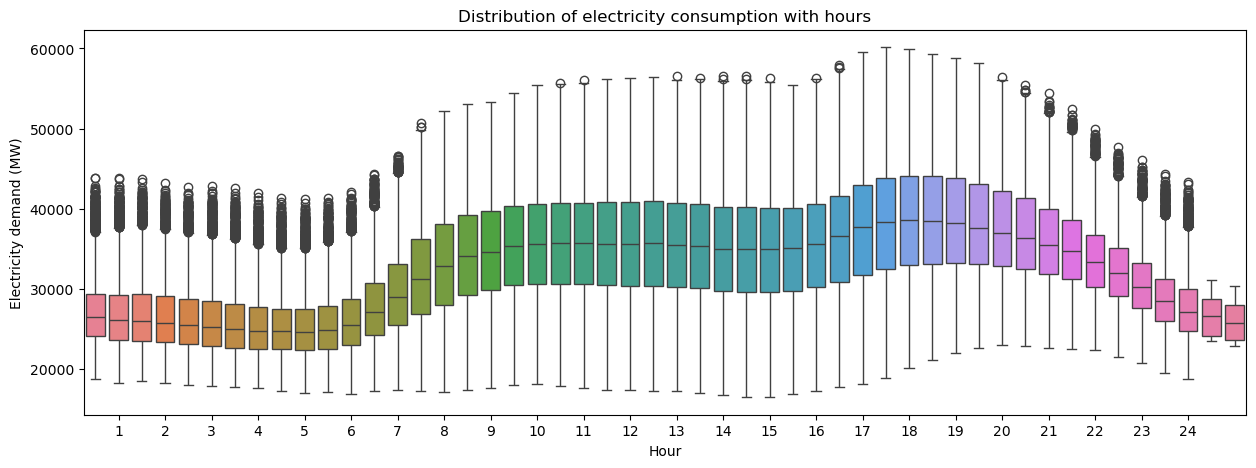

In [34]:
boxplot_electricity_consumption(df=df_demand_clean, 
                                x="settlement_period", 
                                y="tsd",
                                hue="settlement_period",
                                xlabel="Hour",
                                ylabel="Electricity demand (MW)",
                                xticklabel=range(1, 25),
                                title="Distribution of electricity consumption with hours",
                                colours=50)

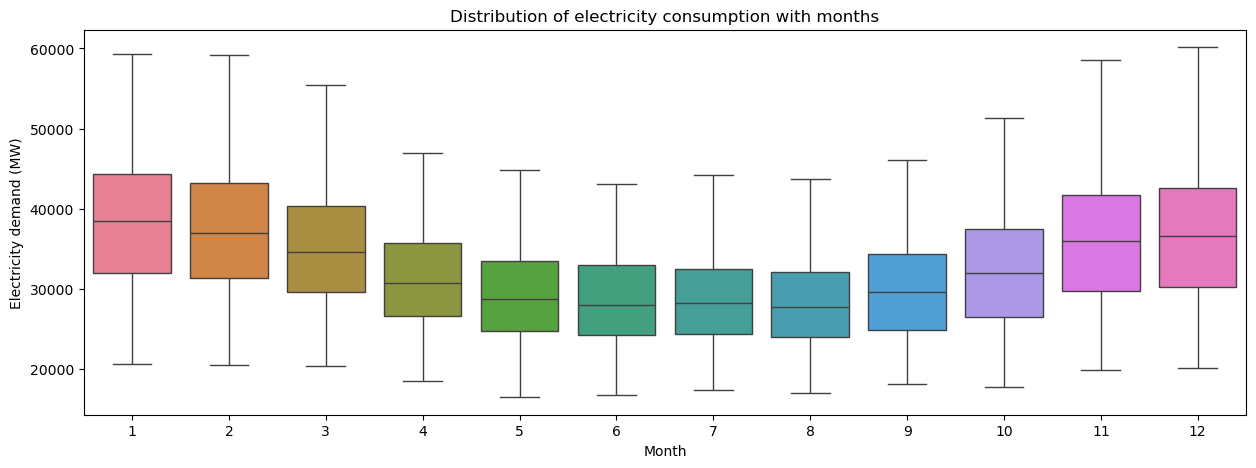

In [35]:
boxplot_electricity_consumption(df=df_demand_clean, 
                                x="month", 
                                y="tsd",
                                xlabel="Month",
                                ylabel="Electricity demand (MW)",
                                hue="month",
                                title="Distribution of electricity consumption with months",
                                colours=12)

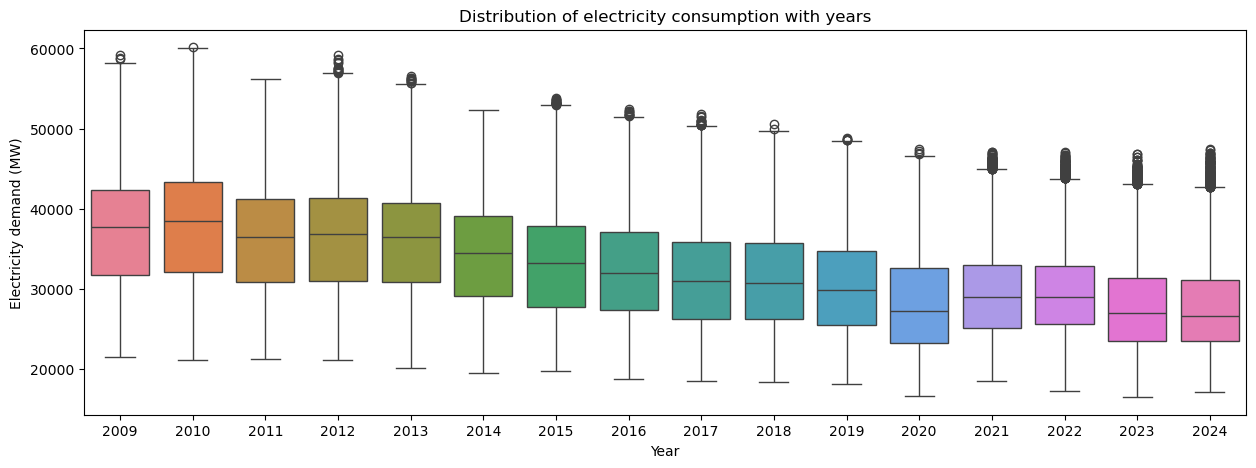

In [36]:
boxplot_electricity_consumption(df=df_demand_clean,
                                x="year",
                                y="tsd",
                                hue="year",
                                xlabel="Year",
                                ylabel="Electricity demand (MW)",
                                title="Distribution of electricity consumption with years",
                                colours=16)

/Users/lizzy/JavaPythonProjects/Mphil/d100_ds/uk_electricity_consumption/core/visualisation/plot_utils.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabel)


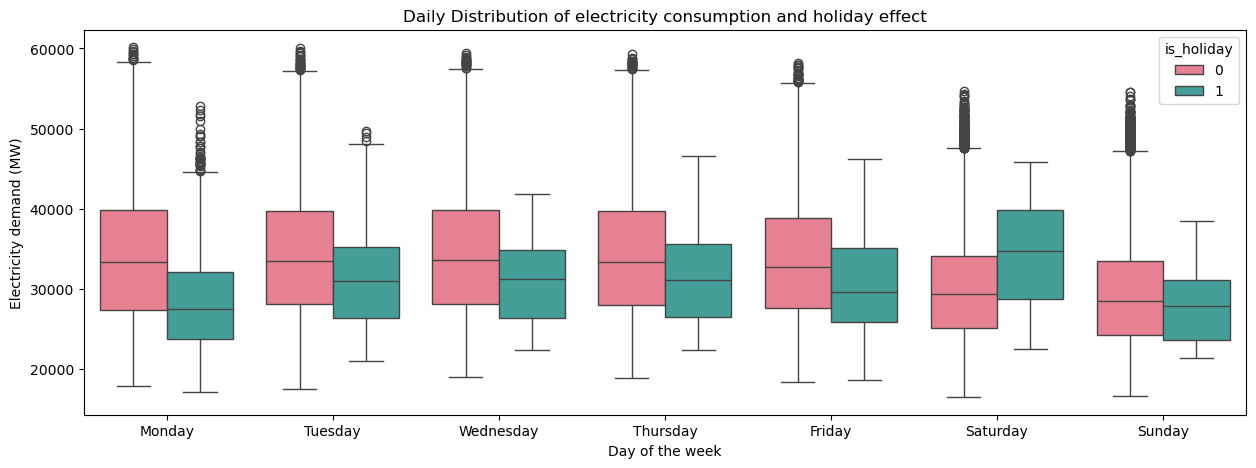

In [37]:
boxplot_electricity_consumption(df=df_demand_clean,
                                x="day_of_week",
                                y="tsd",
                                hue="is_holiday",
                                xlabel="Day of the week",
                                ylabel="Electricity demand (MW)",
                                xticklabel=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
                                title="Daily Distribution of electricity consumption and holiday effect",
                                colours=2,
                                is_legend=True)

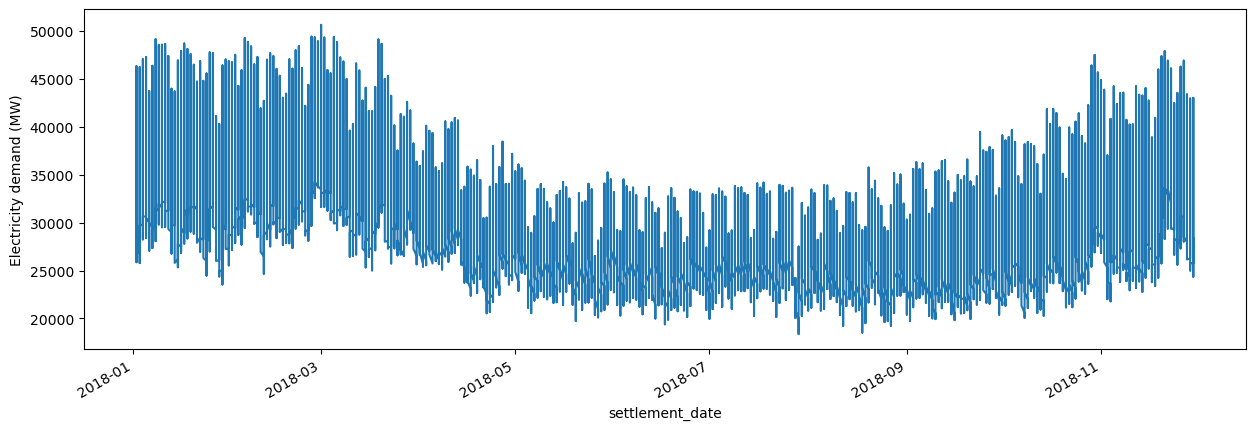

In [38]:
df_demand_clean.loc[(df_demand_clean.index > "2018-01-01") & (df_demand_clean.index < "2018-12-01")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

In [40]:
df_demand_clean.reset_index(inplace=True)
df_model = df_demand_clean.groupby("settlement_date")["tsd"].sum().reset_index()
df_model["is_holiday"] = df_model["settlement_date"].apply(
    lambda x: x in holiday_dates.keys()
)

df_model["is_holiday"] = df_model["is_holiday"].astype(int)
df_model.set_index("settlement_date", inplace=True)
df_model.index = pd.to_datetime(df_model.index)

# Create features that already embedded in the date information and can be used in describe seasonanity.
#  'is_holiday', 'day_of_week', 'week_of_year', 'month', 'quarter',
# 'year', 'is_weekday', 'is_weekend', 'is_summer', 'is_winter'
df_model = create_features(df_model)

In [41]:
# Then join the daily weather data to create the dataset for the model
print("Latest date in consumption: " + str(df_model.index.max().date()))
print("Latest date in weather: " + str(df_weather_by_date.index.max().date()))

df_model = df_model.join(df_weather_by_date, how='inner')
df_model.head()

Latest date in consumption: 2024-11-21
Latest date in weather: 2024-11-12


,tsd,is_holiday,day_of_week,week_of_year,month,quarter,year,is_weekday,is_weekend,is_summer,is_winter,min_temp °c,max_temp °c,rain mm,humidity %,cloud_cover %,wind_speed km/h
2009-01-01,1849363,0,3,1,1,1,2009,1,0,0,1,-1.988072,1.886680,0.114115,83.870775,32.479125,10.300199
2009-01-02,1974406,0,4,1,1,1,2009,1,0,0,1,-0.705765,3.755467,0.046918,88.558648,43.236581,13.721670
2009-01-03,1952054,0,5,1,1,1,2009,0,1,0,1,-2.089463,2.667992,0.102386,80.930417,25.284294,10.890656
2009-01-04,1968670,0,6,1,1,1,2009,0,1,0,1,-2.043738,1.956262,0.517296,83.399602,58.314115,11.992048
2009-01-05,2271471,0,0,2,1,1,2009,1,0,0,1,-1.789264,2.685885,0.772763,84.389662,37.079523,17.214712


In [42]:
df_model.columns

Index(['tsd', 'is_holiday', 'day_of_week', 'week_of_year', 'month', 'quarter',
       'year', 'is_weekday', 'is_weekend', 'is_summer', 'is_winter',
       'min_temp °c', 'max_temp °c', 'rain mm', 'humidity %', 'cloud_cover %',
       'wind_speed km/h'],
      dtype='object')

In [44]:
save_to = Path.cwd().parent / 'data' / 'model_data'
if not save_to.exists():
    save_to.mkdir(parents=True, exist_ok=True)
df_model.to_parquet(save_to / 'model_data.parquet')